# Notas sobre este trabalho
 Este notebook foi desenvolvido no âmbito do desenvolvimento de um artigo científico para a conferência da academia STEM no ano de 2022. Este trabalho deve como autores: João Filipe da Silva Brandão, Fernando Araujo Alves Filho, Elloa Barreto Guedes, Francis Wagner da Silva Correia, Weslley Brito. Foi apresentado no formato palestra. 

Este notebook foi desenvolvido por: Fernando Araujo Alves Filho (faaf.eng19@uea.edu.br | fernandoj.alvesfilho@gmail.com) e João Filipe Da Silva Brandão (jfdsb.eng19@uea.edu.br | hackeru.dll@gmail.com)

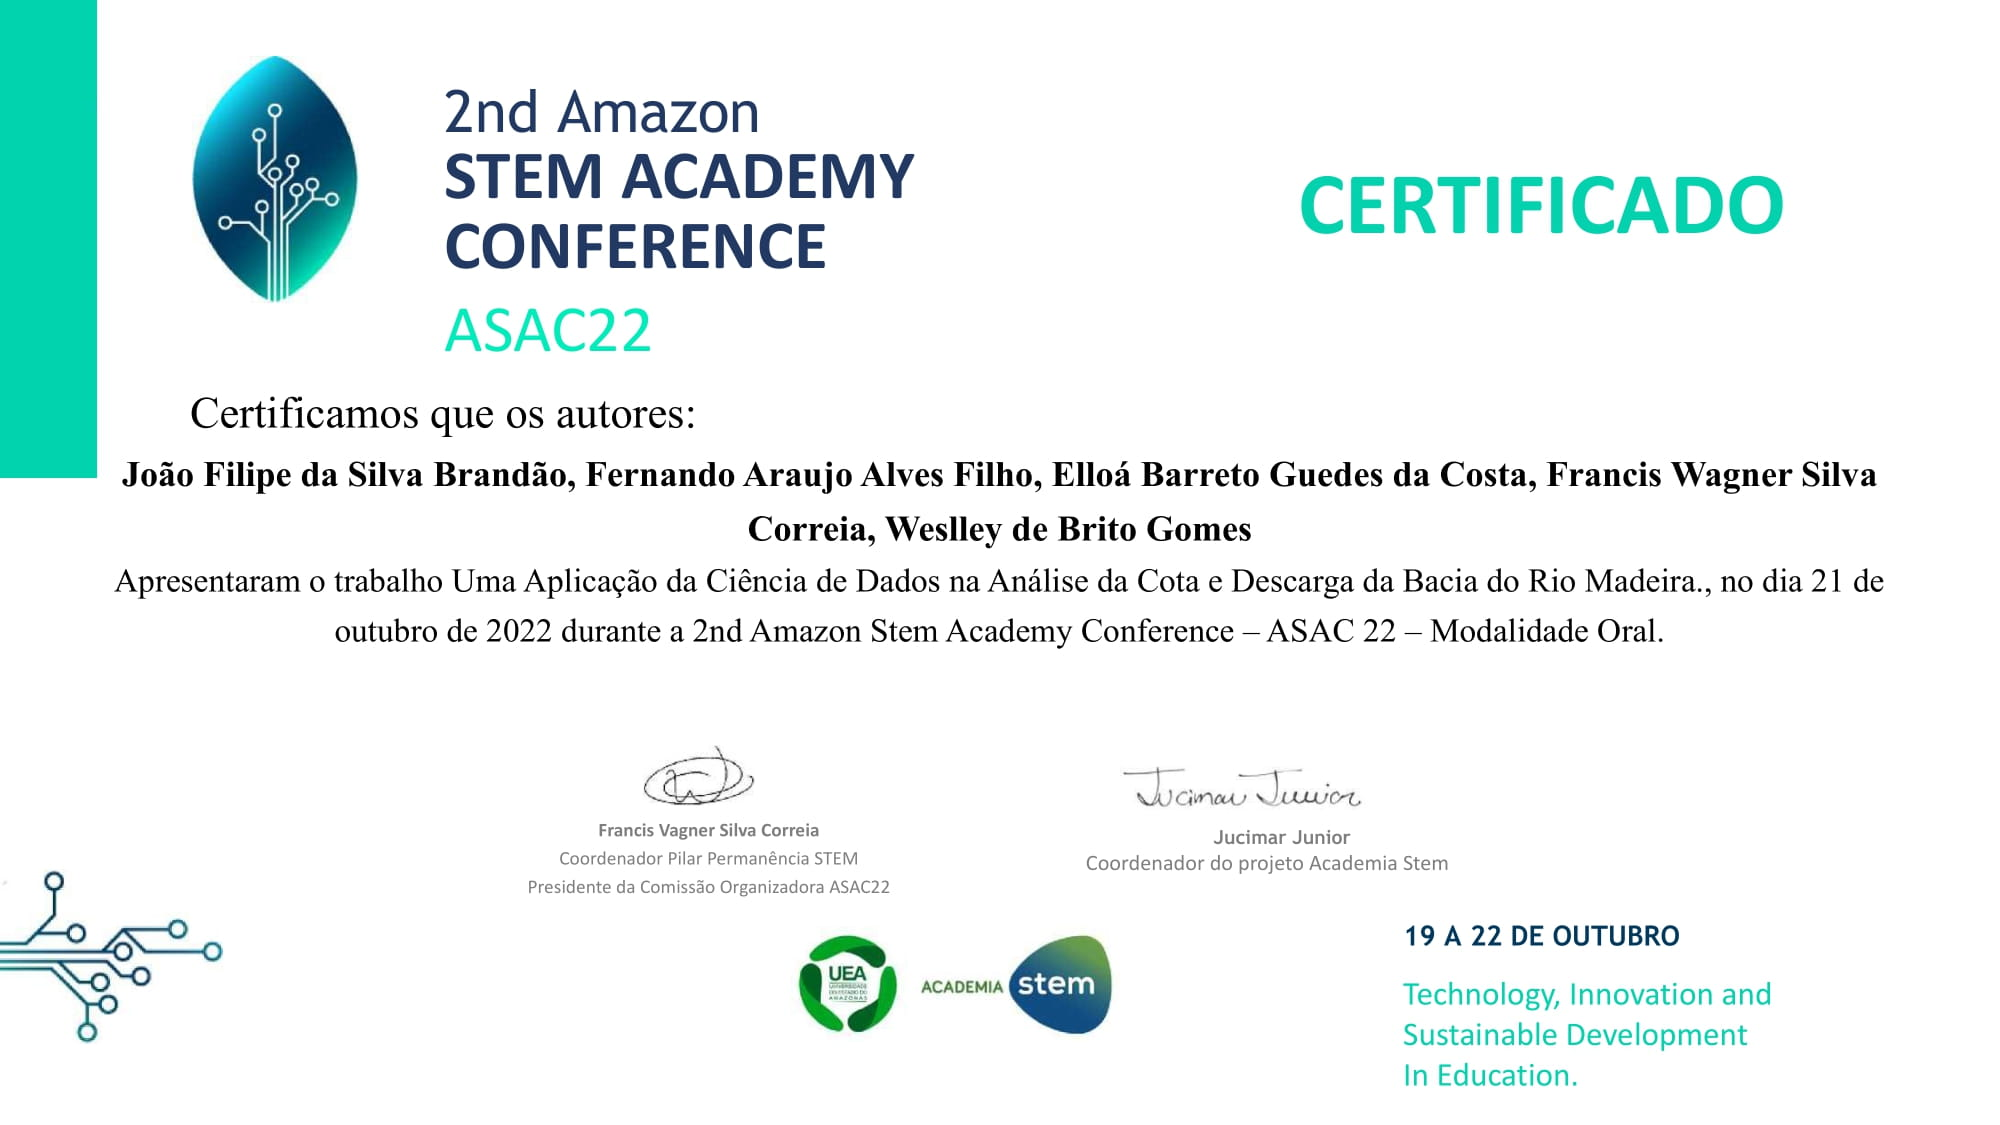

In [1]:
import os
print(os.getcwd())
import contextily as ctx
import geopandas
import rasterio
import pandas as pd
import matplotlib as mtl
import os
import glob
from datetime import datetime
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

/home/fernandoarkade/Documents/Asac_22_datascience/Notebooks


<h1 style=color:black font:SciELO>diretórios do projeto </h1>

<h2 style= color:black> Pasta raiz </h2>

In [2]:
os.chdir('/home/fernandoarkade/Documents/Asac_22_datascience/')

<h2> path de dados e estações </h2>

In [3]:
os.getcwd()

'/home/fernandoarkade/Documents/Asac_22_datascience'

In [4]:
DOC_path = f'{os.getcwd()}//Dados/station_MADEIRA.xlsx'
DOC = pd.read_excel(DOC_path)
estacoes_madeira = list(DOC[DOC["CURSO D'ÁGUA"]=='RIO MADEIRA']['CÓDIGO'])
path = os.getcwd()
print(estacoes_madeira)

[15320002, 15400000, 15630000, 15700000]


<h1> Funções </h1>

<h2>Leitura dos dados </h2>

In [5]:
COTAS = [f"{path}//Dados//COTAS//15320002.txt", f"{path}//Dados//COTAS//15400000.txt",f"{path}//Dados//COTAS//15630000.txt",f"{path}//Dados//COTAS//15700000.txt"]
VAZOES = [f"{path}//Dados//VAZOES//15320002.txt", f"{path}//Dados//VAZOES//15400000.txt",f"{path}//Dados//VAZOES//15630000.txt",f"{path}//Dados//VAZOES//15700000.txt"]
def dados(dado):
    ano = dado['ANO']
    mes = dado['MES']
    dia = dado['DIA']
    medidas = {"DATA":[], "MEDICAO":[]}
    for med in range(len(dado['ANO'])):
        if float(dado['MEDICAO'][med]) > 0:
            d = int(dia[med])
            m = int(mes[med])
            medidas['DATA'].append(datetime.date(int(ano[med]), m, d))
            medidas['MEDICAO'].append(float(dado['MEDICAO'][med]))
    return medidas

def read_archive(path_arquivo):
    lines = [] 
    with open(path_arquivo) as arquivo:
        for line in arquivo:
            lines.append(line.split())
    df = pd.DataFrame(lines, columns= ['DIA', 'MES', 'ANO', 'MEDICAO'])
    return df


<h2>Operações no dataset</h2>

In [6]:

def calcula_media_mensal(df):
    medias_mensais = {'data':[], 'media': []}
    for x in range(len(df)):
        ano = df.DATA[x].year
        mes = df.DATA[x].month
        
        somatorio = 0
        qtd_medicoes = 0
        
        for m in range(x, len(df)):
        
            if df.DATA[m].month != mes:
                break
            else:
                somatorio+=df.MEDICAO[m]
                qtd_medicoes+=1
        if datetime.date(int(ano), mes, 15) not in medias_mensais['data']:
            
            medias_mensais['data'].append(datetime.date(int(ano), mes, 15))
            medias_mensais['media'].append(somatorio/qtd_medicoes)
            
    return medias_mensais



<h2>Plotagem</h2>

In [7]:
import matplotlib.pyplot as plt

def plot(quem, x,y, titulo, x_description, y_description, color, xticks= False, yticks= False, size= (16,3)):

    colors = {'Blue': ('#00243c', '#00507D', '#0392BE', '#07ADC7', '#45C7C9', '#45C7C9', '#D6FFFD'), 
              'Green': ('#FFFFFF','#A3DFC3', '#6AB982', '#5E885B','#4A692D','#618700', '#4A692D')}
    if quem.upper() == 'FERNANDO':
        cor = 'Blue'
        evento = 'Cota'
    else:
        cor = 'Green'
        evento = 'Vazao'
    ax = plt.axes()
    plt.gcf().set_size_inches(size)


    #ax.set_facecolor(colors[cor][color['background']])


    #xticks = [0.1, 0.5, 0.7]
    ax.plot(x,y, color = colors[cor][color['line']])
    
    '''
    plt.setp(ax, xticks=[0.1, 0.5, 0.9], xticklabels=['a', 'b', 'c'],
        yticks=[1, 2, 3])
    
    '''
    
    ax.set_title(str(titulo), fontdict=None, loc='center', pad=None)    
    ax.set_xlabel(x_description)
    ax.set_ylabel(y_description)
    #plt.savefig(f'.{os.getcwd()}/gráficos/simple_graphics/{evento}_{titulo.title()}.png')
    plt.show()
    
    return None

<h1> Leitura dos dados </h1>

<h2>As estações deisponíveis são as que possuem o curso d'água no rio Madeira</h2>

In [8]:
madeira_estacoes = path+'//Dados//station_MADEIRA.xlsx'
df_excel = pd.read_excel(madeira_estacoes)
df_excel[df_excel["CURSO D'ÁGUA"] == 'RIO MADEIRA']

,CÓDIGO,NOME DA ESTAÇÃO,CURSO D'ÁGUA,UF,ENTIDADE,LATITUDE,Unnamed: 6,Unnamed: 7,LONGITUDE,Unnamed: 9,Unnamed: 10,ÁREA KM²,INÍCIO,FIM
7,15320002,ABUNÃ,RIO MADEIRA,RO,ANA,-9,42,11,-65,21,53,899761,2000-01-01,1976-02-01
10,15400000,PORTO VELHO,RIO MADEIRA,RO,ANA,-8,44,12,-63,55,13,954285,2000-01-01,1964-01-01
20,15630000,HUMAITÁ,RIO MADEIRA,AM,ANA,-7,30,19,-63,1,13,1066240,2000-01-01,1931-03-01
23,15700000,MANICORÉ,RIO MADEIRA,AM,ANA,-5,49,0,-61,18,7,1157516,2000-01-01,1967-04-01


<h2> COTAS </h2>

## Leitura dos dados de cota.

Definição de cota: Desnível entre os dois pontos, que foi adicionada ao valor da média das cheias, por estar a área em estudo a montante da Estação Fluviométrica. É interpretação corrente, junto aos órgãos licenciadores, de que o nível mais alto do rio seja o nível da maior cheia ocorrida no local.


Variáveis:

n = indexador que faz referência a lista de dados de cota. 
    {
    
    0 : Abunã 
    
    1 : Porto Velho 
    
    2 : Humaitá
    
    3 : Manicoré
    
    }
    
df_cota = dataframe que armazena os dados de cota lidos

medias = médias mensais, compõe duas séries

        {
        
            data: data da medição
            
            media: Média do mês
            
        }

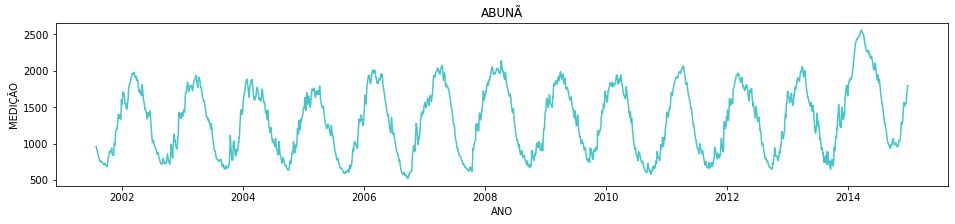

In [9]:
n= 0
df_cota = read_archive(COTAS[n])
CODIGO = estacoes_madeira[n]

df_cota = pd.DataFrame(dados(df_cota))
medias_cota = pd.DataFrame(calcula_media_mensal(df_cota))

plot('FERNANDO', df_cota.DATA, df_cota.MEDICAO, f"{DOC['NOME DA ESTAÇÃO'][DOC['CÓDIGO'][:] == CODIGO].values[0]}",
     'ANO',
     'MEDIÇÃO',
     {'background': 6, 'line': 4, 'y_ticks' : 3})


In [10]:
medias_cota

,data,media
0,2001-07-15,947.000000
1,2001-08-15,810.258065
2,2001-09-15,719.666667
3,2001-10-15,829.870968
4,2001-11-15,988.300000
...,...,...
157,2014-08-15,1255.387097
158,2014-09-15,982.900000
159,2014-10-15,1000.290323
160,2014-11-15,1128.400000


## Leitura dos dados de vazão.

Definição de vazão: Vazão é o volume de fluido que passa por uma seção por determinado período de tempo. Tratando-se de água, essa seção pode ser um rio, canal, estação de tratamento e até residência. Um cálculo específico é utilizado para medir a vazão de um rio, que considera a área e o tempo.


Variáveis:

n = indexador que faz referência a lista de dados de cota. 
    {
    
    0 : Abunã 
    
    1 : Porto Velho 
    
    2 : Humaitá
    
    3 : Manicoré
    
    }
    
df = dataframe que armazena os dados de vazão lidos

medias = médias mensais, compõe duas séries

        {
        
            data: data da medição
            
            media: Média do mês
            
        }

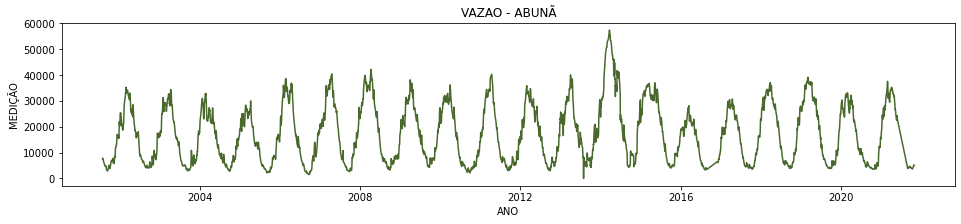

In [11]:
df_vazao = read_archive(VAZOES[n])
CODIGO = estacoes_madeira[n]
df_vazao = pd.DataFrame(dados(df_vazao))
medias_vazao = pd.DataFrame(calcula_media_mensal(df_vazao))
plot('joao', df_vazao.DATA, df_vazao.MEDICAO,
     f"VAZAO - {DOC['NOME DA ESTAÇÃO'][DOC['CÓDIGO'][:] == CODIGO].values[0]}",
     'ANO',
     'MEDIÇÃO',
     {'background': 1, 'line': 4, 'y_ticks' : 3})


In [12]:
medias_vazao

,data,media
0,2001-07-15,7558.003333
1,2001-08-15,5639.537419
2,2001-09-15,3718.324333
3,2001-10-15,5969.363871
4,2001-11-15,8413.188333
...,...,...
233,2021-03-15,32687.596774
234,2021-04-15,33738.340000
235,2021-05-15,25845.474194
236,2021-09-15,4228.690333


# Visualização dos dados

## Visualização das séries temporais em gráficos sobrepostos

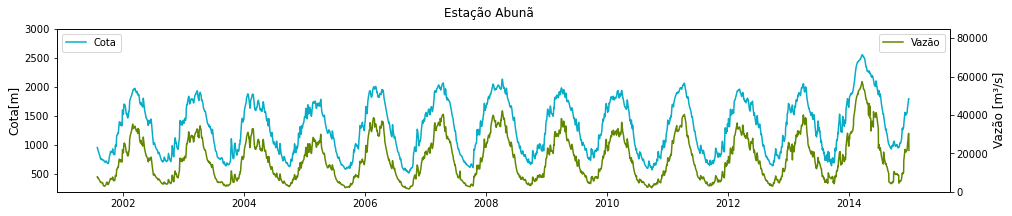

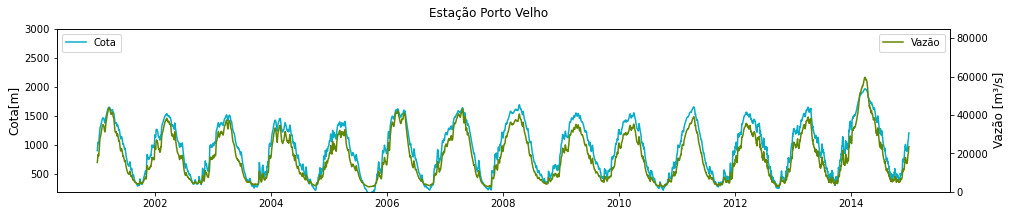

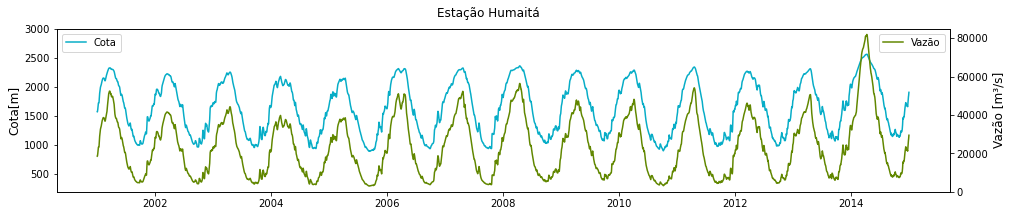

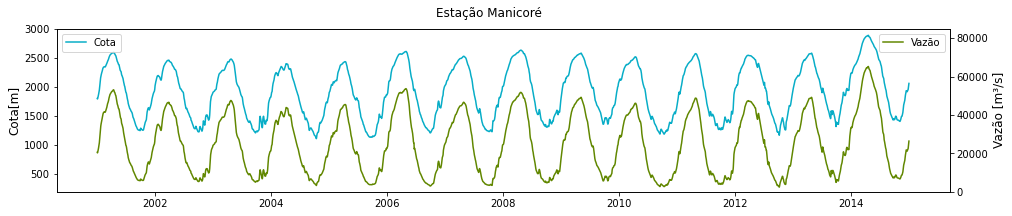

In [13]:
colors = {'Blue': ('#00243c', '#00507D', '#0392BE', '#07ADC7', '#45C7C9', '#45C7C9', '#D6FFFD'), 
              'Green': ('#FFFFFF','#A3DFC3', '#6AB982', '#5E885B','#4A692D','#618700', '#4A692D')}
for n in range(4):
    df_vazao = read_archive(VAZOES[n])
    CODIGO = estacoes_madeira[n]
    df_vazao = pd.DataFrame(dados(df_vazao))
    normalized_vazao=(df_vazao.MEDICAO-df_vazao.MEDICAO.min())/(df_vazao.MEDICAO.max()-df_vazao.MEDICAO.min())


    df_cota  = read_archive(COTAS[n])
    df_cota = pd.DataFrame(dados(df_cota))
    normalized_cota=(df_cota.MEDICAO-df_cota.MEDICAO.min())/(df_cota.MEDICAO.max()-df_cota.MEDICAO.min())

    estacao = (DOC['NOME DA ESTAÇÃO'][DOC['CÓDIGO'][:] == CODIGO].values[0]).title()



    fig, ax1 = plt.subplots(figsize=(16,3))
    ax1.set_ylabel('Cota[m]', size=12)
    fig.suptitle(f'Estação {estacao}')
    ax1.plot(df_cota.DATA, df_cota.MEDICAO, color= colors['Blue'][-4], label = 'Cota')
    ax1.legend(loc = 'upper left')
    ax = plt.gca()
    ax.set_ylim([200, 3000])
    
    ax2 = ax1.twinx()
    ax2.plot(df_vazao.DATA[df_vazao.MEDICAO > 5][:len(df_cota)], df_vazao.MEDICAO[df_vazao.MEDICAO > 5][:len(df_cota)], color= colors['Green'][-2], label = 'Vazão')
    ax2.set_ylabel('Vazão [m³/s]', size= 12)
    ax2.legend(loc='upper right')
    ax = plt.gca()
    ax.set_ylim([0, 85000])
    
    #plt.savefig('.//Documents//'+f"{DOC['NOME DA ESTAÇÃO'][DOC['CÓDIGO'][:] == CODIGO_joao].values[0]}"+'.png', dpi = 200, pad=0, bbox_inches='tight')
    # A versão final do código não precisa salvar as figuras, portanto este trecho foi comentado
plt.show()

## Visualização das médias mensais com desvio padrão
Esta visualização é muito comum na meteorologia, a metodologia foi:
   - Calcular a média do mês em questão (possui medições diárias durante anos)
    
   - calcular o desvio padrão daquele mês ao longo dos anos.
   
   - ex. Janeiro, vou calcular a media de todos os meses de janeiro e seu respectivo desvio padrão.

### Tratamento para fazer esta visualização

In [14]:
import statistics
def day_after(date1, date2):
    c1 = (date1.day  == date2.day) # é um dia depois
    c2 = (date1.month != date2.month) # é no mesmo mês
    c3 = (date1.year == date2.year) # é no mesmo ano
    if c2:
        return True
    return False

def separa_meses(df):
    dicionario = {"DATA": [df.DATA[0]], "MEDICAO":[df.MEDICAO[0]]}
    dataframes = [0]
    for reg in range(1, len(df)-1): # vai rodar a serie inteira
        # agora quero que rode por  mês 
        if day_after(df.DATA[reg], df.DATA[reg+1]): # virou o mes
            #faz uma ultima vez
            data = df.DATA[reg]
            medicao = df.MEDICAO[reg]
            dicionario["DATA"].append(data)
            dicionario["MEDICAO"].append(medicao)
            # Cria o dataframe e adiciona na lista de dfs. Cria um novo dict
            dataframes.append(pd.DataFrame(dicionario))
            dicionario = {"DATA": [df.DATA[reg+1]], "MEDICAO":[df.MEDICAO[reg+1]]} # reseta o dicionario do mes
        else:
            data = df.DATA[reg]
            medicao = df.MEDICAO[reg]
            dicionario["DATA"].append(data)
            dicionario["MEDICAO"].append(medicao)
    return dataframes[1:]
def traduz(mes):
    
    nomes= {1:"janeiro", 2:"fevereiro", 3:"março",4:"abril", 5:"maio", 6:"junho", 7:"julho",
            8:"agosto", 9:"setembro", 10:"outubro", 11:"novembro", 12:"dezembro"}
    return nomes[mes]
def desvio_padrao(valores):
    st = statistics.stdev(valores)
    return st 
    
def media_meses(df):
    dfs_meses = separa_meses(df)
    medias =  {"janeiro":0, "fevereiro":0, "março":0,"abril":0, "maio":0, "junho":0, "julho":0,
            "agosto":0, "setembro":0, "outubro":0, "novembro":0, "dezembro":0}
    n =  {"janeiro":0, "fevereiro":0, "março":0,"abril":0, "maio":0, "junho":0, "julho":0,
            "agosto":0, "setembro":0, "outubro":0, "novembro":0, "dezembro":0}
    valores =  {"janeiro":[], "fevereiro":[], "março":[],"abril":[], "maio":[], "junho":[], "julho":[],
            "agosto":[], "setembro":[], "outubro":[], "novembro":[], "dezembro":[]}
    # somatorio
    for dataframe in dfs_meses:
        mes = dataframe.DATA[0].month
        media_mes = dataframe.MEDICAO.mean()
        mes = traduz(mes)
        medias[mes]+= media_mes
        n[mes]+=1
        valores[mes].append(media_mes)
    #calcula medias
    for k in medias.keys():
        medias[k] = medias[k]/n[k]
        valores[k] = desvio_padrao(valores[k])
    return medias, valores

medias_cota, dp_cota = media_meses(df_cota)
medias_vazao, dp_vazao = media_meses(df_vazao)
desvio_cota_acima = []
desvio_cota_abaixo = []

desvio_vazao_acima = []
desvio_vazao_abaixo = []


for mes in medias_cota.keys():
    desvio_cota_acima.append(medias_cota[mes]+dp_cota[mes])
    desvio_cota_abaixo.append(medias_cota[mes]-dp_cota[mes])
    
    desvio_vazao_acima.append(medias_vazao[mes]+dp_vazao[mes])
    desvio_vazao_abaixo.append(medias_vazao[mes]-dp_vazao[mes])


### Visualização

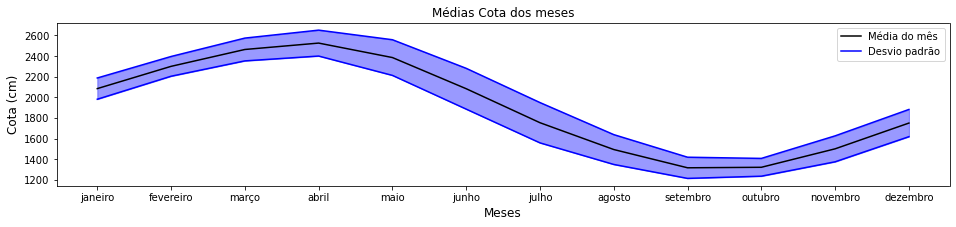

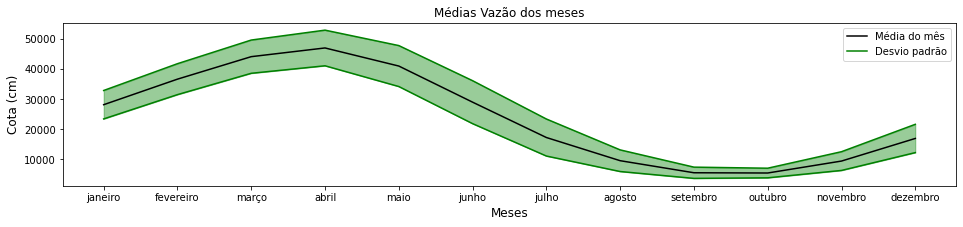

In [15]:
plt.figure(figsize=(16,3))
plt.plot(medias_cota.keys(), medias_cota.values(), color= 'black', label= "Média do mês")
plt.fill_between(medias_cota.keys(), desvio_cota_acima, desvio_cota_abaixo, color='blue', alpha=0.4)
plt.plot(desvio_cota_abaixo, color = 'blue')
plt.plot(desvio_cota_acima, color= 'blue', label="Desvio padrão")
plt.title("Médias Cota dos meses",size=12)
plt.xlabel("Meses", size=12)
plt.ylabel("Cota (cm)", size= 12)
plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.plot(medias_vazao.keys(), medias_vazao.values(), color= 'black', label= "Média do mês")
plt.fill_between(medias_vazao.keys(), desvio_vazao_acima, desvio_vazao_abaixo, color='green', alpha=0.4)
plt.plot(desvio_vazao_acima, color = 'green', label = 'Desvio padrão')
plt.plot(desvio_vazao_abaixo, color= 'green')
plt.title("Médias Vazão dos meses",size=12)
plt.xlabel("Meses", size=12)
plt.ylabel("Cota (cm)", size= 12)
plt.legend()
plt.show()

## Decomposição aditiva - Dados de cota
Definição: 
* Trend: Since the data show four quarter seasonality, a four period moving average operator and a two-period moving average operator is used to estimate the trend component.


* Seasonality: The Generate attribute operator is used to calculate the detrended series by finding the difference between the time series and the 2×4 month moving average values. The same operator also extracts quarter value (Q1, Q2, Q3, Q4) from the Year (e.g., 1996 Q1) attribute. The detrended series has seasonality and noise. To calculate the seasonality, the quarter values have to be averaged using the Aggregate operator. This gives seasonality values for one year. The Join operator is used to repeat the seasonal component for every Q1, Q2, Q3 and Q4 records.


* Noise: Noise is calculated by the difference of the time series with the combination of trend and seasonality.


fonte: https://www.sciencedirect.com/topics/mathematics/additive-decomposition

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


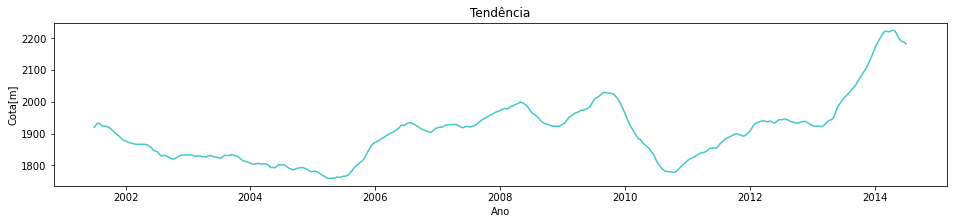

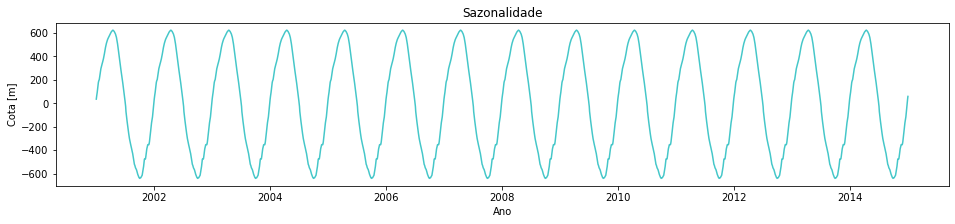

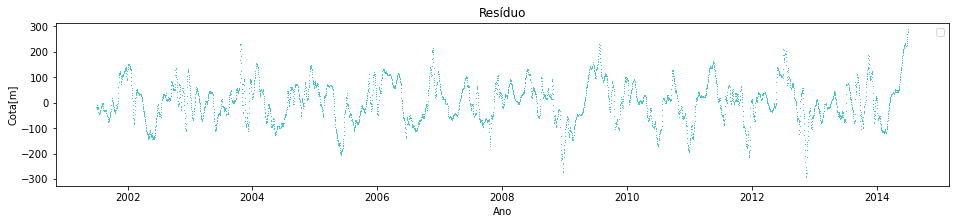

In [16]:
result = seasonal_decompose(df_cota['MEDICAO'], model='Aditive', period=365)

tendencia = result.trend
sazonal = result.seasonal
residuo = result.resid

colors = {'Blue': ('#00243c', '#00507D', '#0392BE', '#07ADC7', '#45C7C9', '#45C7C9', '#D6FFFD'),
          'Green': ('#FFFFFF','#A3DFC3', '#6AB982', '#5E885B','#4A692D','#618700', '#4A692D')}
    

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))

plt.plot(df_cota.DATA, tendencia, color= colors['Blue'][-2])
plt.title('Tendência', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')
plt.ylabel('Cota[m]', loc='center')

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))

plt.plot(df_cota.DATA, sazonal, color= colors['Blue'][-2])
plt.title('Sazonalidade', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')
plt.ylabel('Cota [m]', loc='center')

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))
# nao denotar
plt.plot(df_cota.DATA, residuo,',' ,color= colors['Blue'][-2])
plt.title('Resíduo', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')
plt.ylabel('Cota[m]', loc='center')

plt.legend()
    
plt.show()

## Decomposição aditiva - Dados de vazão

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


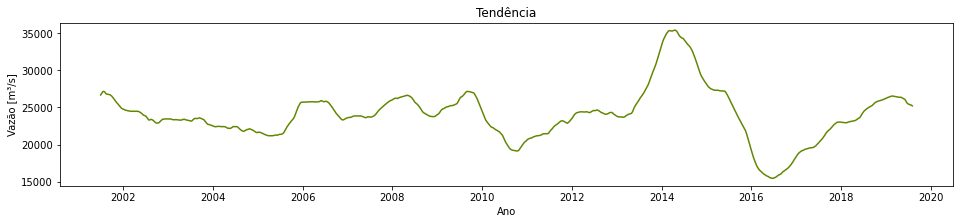

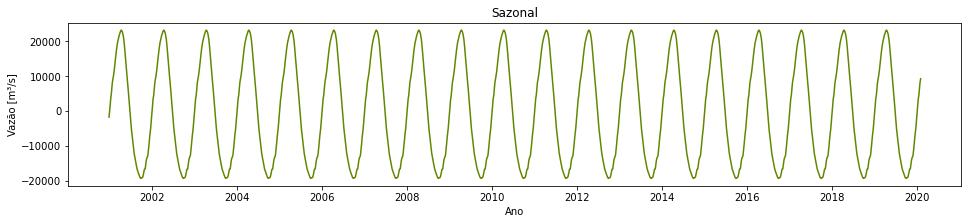

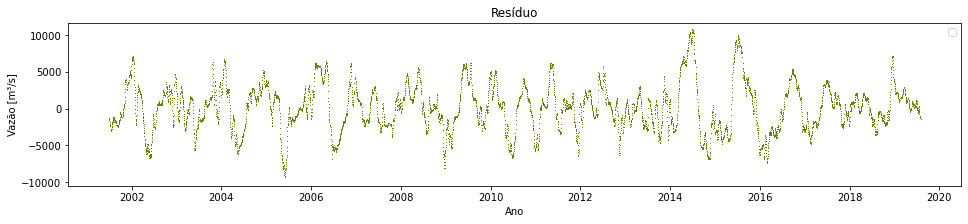

In [17]:
result = seasonal_decompose(df_vazao['MEDICAO'], model='Aditive', period=365)

tendencia = result.trend
sazonal = result.seasonal
residuo = result.resid

colors = {'Blue': ('#00243c', '#00507D', '#0392BE', '#07ADC7', '#45C7C9', '#45C7C9', '#D6FFFD'),
          'Green': ('#FFFFFF','#A3DFC3', '#6AB982', '#5E885B','#4A692D','#618700', '#4A692D')}
    

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))

plt.plot(df_vazao.DATA, tendencia, color= colors['Green'][-2])
plt.title('Tendência', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')
plt.ylabel('Vazão [m³/s]', loc='center')

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))

plt.plot(df_vazao.DATA, sazonal, color= colors['Green'][-2])
plt.title('Sazonal', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')
plt.ylabel('Vazão [m³/s]', loc='center')

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))
# nao denotar
plt.plot(df_vazao.DATA, residuo,',' ,color= colors['Green'][-2])
plt.title('Resíduo', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')
plt.ylabel('Vazão [m³/s]', loc='center')

plt.legend()
    
plt.show()

### Sobreposição de gráficos

In [18]:
## Normalização para que os dados fiquem na mesma dimensão

normalized_vazao=(df_vazao.MEDICAO-df_vazao.MEDICAO.min())/(df_vazao.MEDICAO.max()-df_vazao.MEDICAO.min())
normalized_cota = (df_cota.MEDICAO-df_cota.MEDICAO.min())/(df_cota.MEDICAO.max()-df_cota.MEDICAO.min())

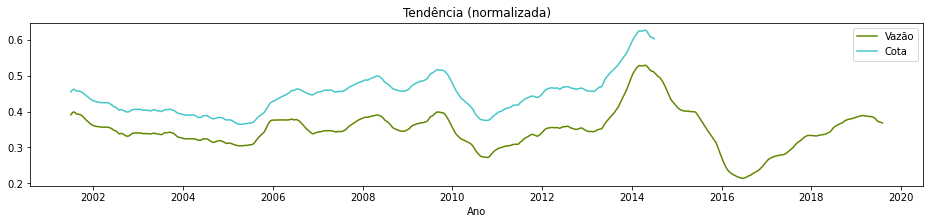

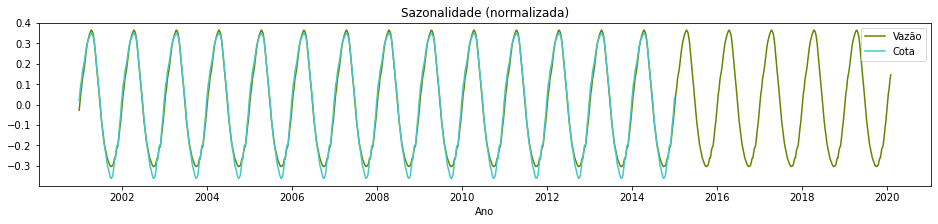

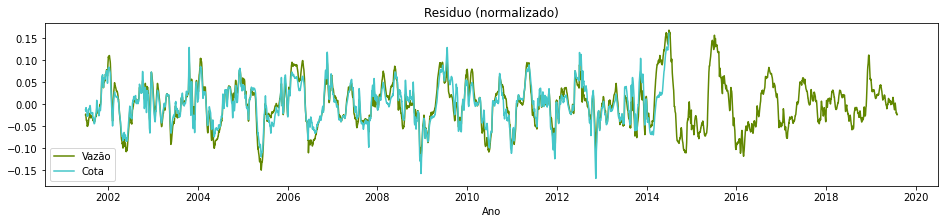

In [19]:
result_c = seasonal_decompose(normalized_cota, model='Aditive', period=365)
tendencia_c = result_c.trend
sazonal_c = result_c.seasonal
residuo_c = result_c.resid


result_v = seasonal_decompose(normalized_vazao, model='Aditive', period=365)
tendencia_v = result_v.trend
sazonal_v = result_v.seasonal
residuo_v = result_v.resid





colors = {'Blue': ('#00243c', '#00507D', '#0392BE', '#07ADC7', '#45C7C9', '#45C7C9', '#D6FFFD'),
          'Green': ('#FFFFFF','#A3DFC3', '#6AB982', '#5E885B','#4A692D','#618700', '#4A692D')}
    
#/////////////////////////// Tendencia

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))


plt.plot(df_vazao.DATA, tendencia_v, color= colors['Green'][-2], label="Vazão")
plt.title('Tendência (normalizada)', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')

plt.plot(df_cota.DATA, tendencia_c, color= colors['Blue'][-2], label = "Cota")
plt.xlabel('Ano', loc= 'center')
plt.legend()

#/////////////////////////// Sazonalidade

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))


plt.plot(df_vazao.DATA, sazonal_v, color= colors['Green'][-2], label="Vazão")
plt.title('Sazonalidade (normalizada)', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')

plt.plot(df_cota.DATA, sazonal_c, color= colors['Blue'][-2], label = "Cota")
plt.xlabel('Ano', loc= 'center')
plt.legend()




#/////////////////////////// Residuo (não denotar no artigo)

plt.figure(figsize=(16,3))
plt.gcf().set_size_inches((16,3))


plt.plot(df_vazao.DATA, residuo_v, color= colors['Green'][-2], label="Vazão")
plt.title('Residuo (normalizado)', loc= 'center', pad=None)
plt.xlabel('Ano', loc= 'center')

plt.plot(df_cota.DATA, residuo_c, color= colors['Blue'][-2], label = "Cota")
plt.xlabel('Ano', loc= 'center')
plt.legend()

plt.show()

## Localização das Estações

In [20]:
import geopandas as gpd
import shapely.geometry

Estes dados foram coletados de estações fluviométricas localizadas ao longo do rio Madeira. Esta seção visa mostrar a localização destas estações

<h3 style= color:red> Localização dos arquivos que contém as formas dos mapas</h3>

In [21]:
shp_path = './/Dados//SHAPES//Madeira_Wat.json'
br_path = './/Dados//mapas//brazil_geo.json'

In [22]:
br_map= gpd.read_file(br_path)
shp_madeira = gpd.read_file(shp_path)

#### Localização das estações

In [23]:
## ESTACOES
GLOC_ABUNA = [-9.7030556, -65.3647222]
GLOC_PORTOVELHO = [-8.7366667, -63.9202778] 
GLOC_HUMAITA = [-7.5052778, -63.0202778]
GLOC_MANICORE =  [-5.8166667, -61.3019444]
estacoes = [GLOC_ABUNA, GLOC_PORTOVELHO, GLOC_HUMAITA, GLOC_MANICORE]

df = pd.DataFrame(
    {'Estacao': ['Abunã', 'Porto Velho', 'Humaita', 'Manicore'],
     'Latitude': [-9.7030556, -8.7366667, -7.5052778,-5.8166667],
     'Longitude': [-65.3647222, -63.9202778, -63.0202778, -61.3019444]})
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

### Mapa mundi

In [24]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
newdf = gpd.overlay(world[world.name == 'Brazil'], shp_madeira, how="intersection")

/tmp/ipykernel_8642/3750084678.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: EPSG:4326

  newdf = gpd.overlay(world[world.name == 'Brazil'], shp_madeira, how="intersection")


### Construção dos gráficos
Note que, para adicionar um fundo nos mapas, utilize a biblioteca contextily (cx). Trechos do código estão comentados pois não são mais relevantes após a publicação do trabalho.

Você pode buscar fundos (contextos para o mapa) na bibliotexa contextily:

https://contextily.readthedocs.io/en/latest/intro_guide.html

https://contextily.readthedocs.io/en/latest/reference.html

[]

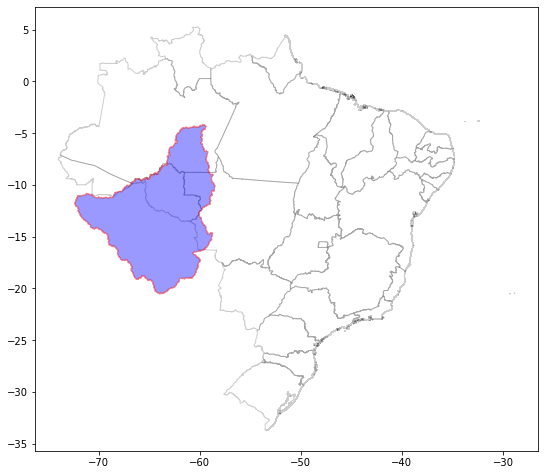

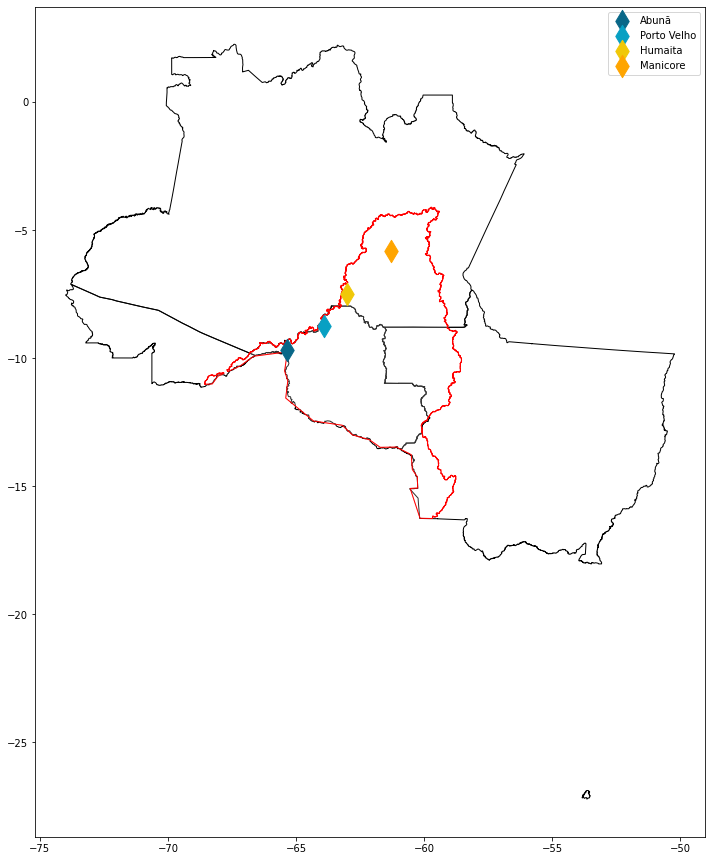

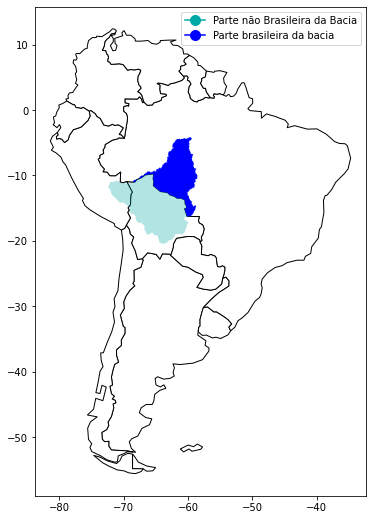

In [25]:
from PIL import Image
from shapely.geometry import Point
import contextily as cx
import matplotlib.lines as mlines

#MAPA DO BRASIL
fig,ax = plt.subplots(figsize=(9,16))
br_map.plot(color= 'white', alpha= 0.2, edgecolor= 'black', ax= ax)

#cx.add_basemap(ax, crs= br_map.crs, source= ctx.providers.Stamen.TonerLite)
shp_madeira.plot(color='blue', ax=ax, alpha= 0.4, edgecolor= 'red')

#cx.add_basemap(ax, crs=br_map.crs, source=ctx.providers.Gaode.Satellite)
#plt.savefig('.//Documents//Dados//mapa_AMERICA_DO_SUL.png', dpi = 500, pad=0, bbox_inches='tight')
plt.plot()


########################## MAPA DA REGIÃO NORTE 
fig,ax = plt.subplots(figsize=(12,24))
a= 1
c = 'none'
br_map[br_map.name== "Amazonas"].plot(color = c, edgecolor='black', ax= ax, alpha= a)
br_map[br_map.name== "Acre"].plot(color= c, edgecolor = 'black', ax= ax, alpha= a)
br_map[br_map.name== "Rondônia"].plot(color=c, edgecolor='black', ax=ax, alpha= a) 
br_map[br_map.name== "Mato Grosso"].plot(color=c, edgecolor='black', ax=ax, alpha= a) 
newdf.plot(color='white', edgecolor = 'red', ax=ax, alpha= 0.2)
newdf.plot(color='none', edgecolor = 'red', ax=ax, alpha= 1)


# Criando imagem 
#mapa_maior = Image.new('RGB', (1200, 1080), color= (256,256,256))
#br = Image.open('.//Documents//Dados//mapa.png')
#regiao_norte= Image.open('.//Documents//Dados//norte.png')
#mapa_maior.paste(regiao_norte, (0,0))

GLOC_ABUNA = [-9.7030556, -65.3647222]
GLOC_PORTOVELHO = [-8.7366667, -63.9202778] 
GLOC_HUMAITA = [-7.5052778, -63.0202778]
GLOC_MANICORE =  [-5.8166667, -61.3019444]

estacoes = pd.DataFrame([GLOC_ABUNA, GLOC_PORTOVELHO, GLOC_HUMAITA, GLOC_MANICORE], columns = ['latitude', 'longitude'])

geometry = [Point(xy) for xy in zip(estacoes['longitude'], estacoes['latitude'])]
estacoes['pontos'] = geometry
gdf[gdf.Estacao == 'Abunã'].plot(marker = 'd', color= '#086788', ax=ax, label= 'Abunã', markersize=250)
gdf[gdf.Estacao == 'Porto Velho'].plot(marker = 'd',color= '#07a0c3', ax= ax, label= 'Porto Velho', markersize=250)
gdf[gdf.Estacao == 'Humaita'].plot(marker = 'd',color= '#f0c808', ax=ax, label = 'Humaita', markersize=250)
gdf[gdf.Estacao == 'Manicore'].plot(marker = 'd',color='orange', ax=ax, label= 'Manicore', markersize=250)
#cx.add_basemap(ax, crs= br_map.crs, source= ctx.providers.Gaode.Satellite)
#cx.add_basemap(ax, crs=br_map.crs, source=ctx.providers.Gaode.Satellite)
plt.legend()
#plt.savefig('.//Documents//Dados//norte.png',dpi = 500, pad=0, bbox_inches='tight')


fig,ax = plt.subplots(figsize=(16,9))
world[world.continent=='South America'].plot(ax=ax,color = 'white', edgecolor='black')

shp_madeira.plot(ax=ax, color= '#00A8A8', alpha= 0.3) 
newdf.plot(color= 'blue', ax=ax) 
non_br = mlines.Line2D([], [], color='#00A8A8', marker='o',
                          markersize=10, label='Parte não Brasileira da Bacia') #?

br = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=10, label='Parte brasileira da bacia')
plt.legend(handles=[non_br, br])
#cx.add_basemap(ax, crs=br_map.crs, source=ctx.providers.Gaode.Satellite)
plt.plot()



# Créditos | Referências
Estes repositórios ajudaram ou serviram como base para fazer parte deste trabalho. Muito dos dados de mapas foram coletados destes repositórios.

https://github.com/kelvins/Municipios-Brasileiros

https://github.com/carolinabigonha/br-atlas

https://github.com/tbrugz/geodata-br